In [6]:
import os
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from mlp import MLP

DIR_PATH = os.getcwd() + '/../'

In [7]:
data_traj = np.load(DIR_PATH + 'data/demo_reach_object_16x16_200_steps.npz')

x = data_traj['demo_image_sequences']
y = data_traj['demo_action_sequences']

n_steps = len(y)
print('Number of sequences:', n_steps)

Number of sequences: 200


In [8]:
# Split
random_idx = np.random.permutation(n_steps)

n_val = int(0.1 * n_steps)
n_train = n_steps - n_val

val_idx = random_idx[: n_val]
train_idx = random_idx[n_val : n_val+n_train]

val_x = x[val_idx]
val_y = y[val_idx]

train_x = x[train_idx]
train_y = y[train_idx]

In [9]:
# Analyse (train set only)
print(train_x.min(axis=(0,1,2)))
print(train_x.max(axis=(0,1,2)))
print(train_x.mean(axis=(0,1,2)))
print(train_x.std(axis=(0,1,2)))
print()
print(np.concatenate([train_y.min(axis=0).reshape(-1, 1), train_y.max(axis=0).reshape(-1, 1)], axis=1))

[0. 0. 0.]
[1.         0.96862745 0.9490196 ]
[0.6070568  0.49726567 0.4078368 ]
[0.2681741  0.19930756 0.21068053]

[[ 5.15173797e-05  2.03431124e-03]
 [-1.50202860e-03 -1.66850986e-05]
 [-2.49941348e-03  1.35694957e-03]
 [-8.65011667e-03  2.23942383e-03]
 [-1.05957808e-02  4.66147320e-03]
 [-1.24200236e-02  9.70158600e-04]
 [-9.99999938e-01 -9.99921876e-01]]


In [10]:
train_y.mean(axis=0)

array([ 6.51108440e-04, -8.76343310e-04, -1.80663629e-03,  8.36651455e-05,
       -6.75153840e-04, -6.93653228e-03, -9.99951854e-01])

In [11]:
train_y.std(axis=0)

array([4.01822027e-04, 3.80544307e-04, 9.83347715e-04, 2.35469863e-03,
       2.37449419e-03, 6.04374143e-03, 3.65683586e-05])

In [41]:
'''
def normalize(x_data, y_data):
    normal_x = x_data
    normal_y = (y_data - train_y.mean(axis=0).reshape(1, -1)) / train_y.std(axis=0).reshape(1, -1)
    return normal_x, normal_y
'''
def normalize(x_data, y_data):
    normal_x = x_data
    normal_y = y_data * 1000
    return normal_x, normal_y

normal_train_x, normal_train_y = normalize(train_x, train_y)
normal_val_x, normal_val_y = normalize(val_x, val_y)

In [42]:
for i in range(3):
    print(normal_train_x[:,:,:,i].min(), normal_train_x[:,:,:,i].max())
    
for i in range(7):
    print(normal_train_y[:,i].min(), normal_train_y[:,i].max())

0.0 1.0
0.0 0.96862745
0.0 0.9490196
0.05151737971975147 2.0343112415802986
-1.50202859858016 -0.016685098621597082
-2.4994134818663585 1.3569495704902177
-8.650116671318084 2.239423834273189
-10.595780824061094 4.661473203318984
-12.420023560599935 0.9701585997975194
-999.999937663536 -999.9218760149191


In [43]:
class DemoDataset(Dataset):
    def __init__(self, data_x, data_y):
        self.x = torch.as_tensor(data_x, dtype=torch.float32).permute(0, 3, 1, 2)
        self.y = torch.as_tensor(data_y, dtype=torch.float32)[:, :3]
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [44]:
train_set = DemoDataset(normal_train_x, normal_train_y)
v_set = DemoDataset(normal_val_x, normal_val_y)

#train_set = DemoDataset(train_x, train_y)
#v_set = DemoDataset(val_x, val_y)

len(train_set), len(v_set), train_set.x.shape, train_set.y.shape

(180, 20, torch.Size([180, 3, 16, 16]), torch.Size([180, 3]))

In [90]:
train_loader = DataLoader(train_set, batch_size=45, shuffle=True, drop_last=True)
v_loader = DataLoader(v_set, batch_size=64, shuffle=False, drop_last=False)

In [91]:
#model = ConvNet1(n_classes=6)
model = MLP(layers_dim=(16*16*3, 16, 3))
print('MODEL INFO:', model, sep='\n')

MODEL INFO:
MLP(
  (layers): Sequential(
    (0): Linear(in_features=768, out_features=16, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=16, out_features=3, bias=True)
  )
)


In [92]:
sum_total_learnable_params = 0
for param in model.parameters():
    print(param.shape)
    sum_total_learnable_params += np.prod(np.array(param.shape))
print("Number of learnable parameters:", sum_total_learnable_params)

torch.Size([16, 768])
torch.Size([16])
torch.Size([3, 16])
torch.Size([3])
Number of learnable parameters: 12355


In [93]:
def train(model, train_loader, v_loader, n_epochs):
    device = torch.device('cpu')
    model.to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    loss_logger = {'loss':[], 'vloss':[], 'loss_class':[], 'vloss_class':[]}

    for epoch in range(n_epochs):
        #print(f"Starting epoch {epoch}/{n_epochs}", end=" ")
        for batch, (x, y) in enumerate(train_loader):
            model.train()
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model.forward(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            if batch % 1 == 0:
                model.eval()
                with torch.no_grad():
                    loss_logger['loss'].append(loss.item())
                    loss_per_class = ((y - y_pred)**2).mean(axis=0).numpy()
                    loss_logger['loss_class'].append(loss_per_class)
                    x_val, y_val = v_loader.dataset.x.to(device), v_loader.dataset.y.to(device)
                    y_pred = model.forward(x_val)
                    v_loss_per_class = ((y_val - y_pred)**2).mean(axis=0).numpy()
                    v_loss = v_loss_per_class.mean().item()
                    loss_logger['vloss'].append(v_loss)
                    loss_logger['vloss_class'].append(v_loss_per_class)
        #print('vloss', loss.item())
    return loss_logger

In [113]:
model = MLP(layers_dim=(16*16*3, 32, 3))
loss_log = train(model, train_loader, v_loader, n_epochs=5000)

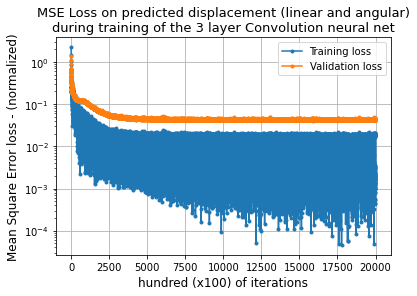

In [114]:
plt.plot(loss_log['loss'], '.-', label='Training loss')
plt.plot(loss_log['vloss'], '.-', label='Validation loss')
plt.title("MSE Loss on predicted displacement (linear and angular)\nduring training of the 3 layer Convolution neural net", fontsize=13)
plt.ylabel("Mean Square Error loss - (normalized)", fontsize=12)
plt.xlabel("hundred (x100) of iterations", fontsize=12)
plt.yscale('log')
plt.legend()
plt.grid()

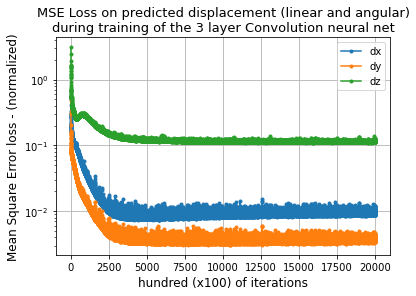

In [115]:
plt.plot(np.stack(loss_log['vloss_class']), '.-')
plt.yscale('log')
#plt.plot(loss_log['loss'], '.-', label='Validation loss')
plt.title("MSE Loss on predicted displacement (linear and angular)\nduring training of the 3 layer Convolution neural net", fontsize=13)
plt.ylabel("Mean Square Error loss - (normalized)", fontsize=12)
plt.xlabel("hundred (x100) of iterations", fontsize=12)
plt.legend(('dx', 'dy', 'dz'))
plt.grid()

In [80]:
min(loss_log['vloss']), min(loss_log['loss']), np.stack(loss_log['vloss_class']).min(axis=0), np.stack(loss_log['loss_class']).min(axis=0)

(0.047621648758649826,
 0.005363536532968283,
 array([0.01414675, 0.00683496, 0.11898609], dtype=float32),
 array([0.00706524, 0.00063498, 0.00839038], dtype=float32))

In [89]:
min(loss_log['vloss']), min(loss_log['loss']), np.stack(loss_log['vloss_class']).min(axis=0), np.stack(loss_log['loss_class']).min(axis=0)

(0.04508332535624504,
 0.00016074439918156713,
 array([0.01210704, 0.0057893 , 0.1138881 ], dtype=float32),
 array([2.0224743e-05, 1.1512718e-05, 1.5566341e-04], dtype=float32))

In [100]:
min(loss_log['vloss']), min(loss_log['loss']), np.stack(loss_log['vloss_class']).min(axis=0), np.stack(loss_log['loss_class']).min(axis=0)

(0.04507988691329956,
 2.755519290076336e-06,
 array([0.01241518, 0.00614436, 0.11282728], dtype=float32),
 array([1.2787652e-06, 7.2160702e-07, 3.0097694e-06], dtype=float32))

In [116]:
min(loss_log['vloss']), min(loss_log['loss']), np.stack(loss_log['vloss_class']).min(axis=0), np.stack(loss_log['loss_class']).min(axis=0)

(0.040911413729190826,
 4.6048546209931374e-05,
 array([0.00737013, 0.00307417, 0.10929243], dtype=float32),
 array([1.2397300e-05, 5.9023705e-06, 3.3040960e-05], dtype=float32))

In [109]:
min(loss_log['vloss']), min(loss_log['loss']), np.stack(loss_log['vloss_class']).min(axis=0), np.stack(loss_log['loss_class']).min(axis=0)

(0.045499976724386215,
 0.0003296082722954452,
 array([0.01178504, 0.00482231, 0.11758278], dtype=float32),
 array([2.5333170e-04, 8.8227134e-05, 5.6912698e-04], dtype=float32))